# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [3]:
import sys
sys.path.append("/run/media/sijanpaudel/New Volume/New folder/llm_engineering/")

In [4]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [5]:
from LLMHandler import LLMHandler
from key_utils import get_next_key

In [5]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [6]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [7]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from testing import Tester

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [8]:
openai = OpenAI()
claude = Anthropic()

In [9]:
%matplotlib inline

In [10]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# Before we look at the Frontier

## There is one more model we could consider

In [11]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [12]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [13]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $374.41 Error: $254.41 SLE: 1.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $80.00 Truth: $225.11 Error: $145.11 SLE: 1.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $35.00 Truth: $61.68 Error: $26.68 SLE: 0.31 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $350.00 Truth: $599.99 Error: $249.99 SLE: 0.29 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $75.00 Truth: $16.99 Error: $58.01 SLE: 2.08 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.00 Truth: $31.99 Error: $19.99 SLE: 0.87 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $115.00 Truth: $101.79 Error: $13.21 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $100.00 Truth: $289.00 Error: $189.00 SLE: 1.11 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $300.00 Truth: $635.86 Error: $335.86 SLE: 0.56 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $80.00 Truth: $65.99 Error: $14.01 SLE: 0.0

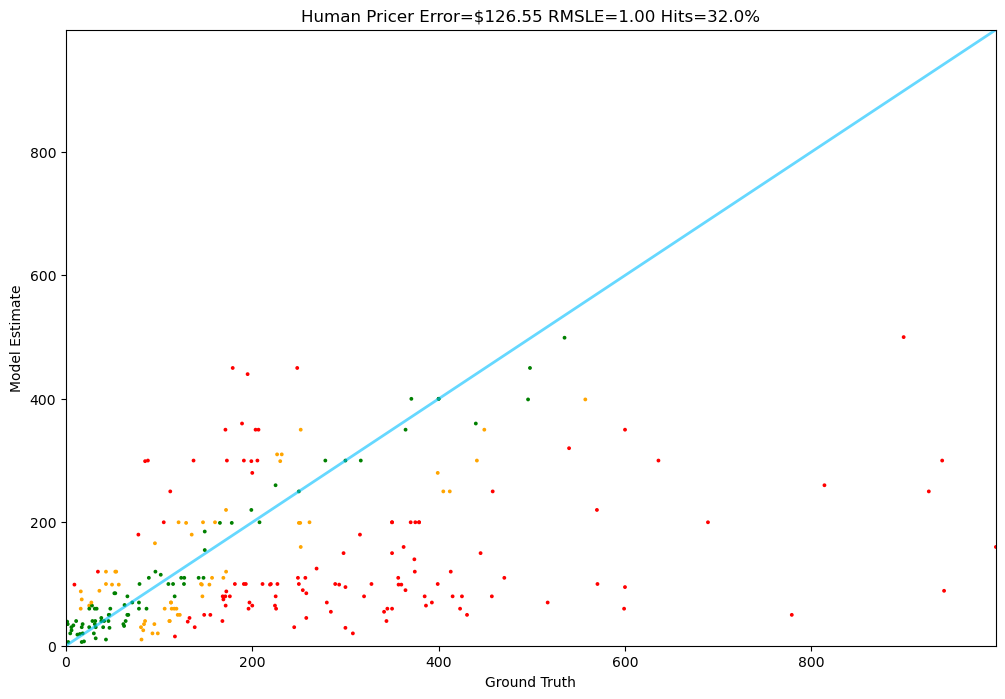

In [20]:
Tester.test(human_pricer, test)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [50]:
from langchain_google_genai import ChatGoogleGenerativeAI
api_key , _ = get_next_key()
model = ChatGoogleGenerativeAI(model = "gemini-2.5-pro",api_key = api_key)

In [58]:
resp= model.invoke("What is communication in 2 lines")

In [59]:
resp.content

'Communication is the two-way process of sending and receiving information, ideas, or feelings.\nIts ultimate goal is to create a shared understanding between the sender and the receiver.'

In [99]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [14]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.
    # The detailed system message that sets the context, rules, and examples.
system_message = """You are an expert Amazon marketplace pricing analyst. Your sole task is to predict the most accurate selling price for a product based on its description, using your deep understanding of Amazon's competitive landscape, consumer psychology, and product positioning.

Analyze the provided product description by following a step-by-step reasoning process before determining the final price.

**Step-by-Step Reasoning Guide:**

1.  **Brand & Category Analysis:** First, identify the brand's strength (e.g., premium like Apple, budget like a generic brand) and the product's primary category (e.g., Electronics, Home & Kitchen, Beauty).
2.  **Feature & Specification Evaluation:** Assess the product's key features, materials, and specifications. More features or higher-quality materials suggest a higher price point.
3.  **Competitive Positioning:** Consider signals of market position, such as "bestseller" or "Amazon's Choice" mentions, and implied customer ratings. A product with high ratings (4.5+ stars) can command a premium.
4.  **Packaging & Variations:** Note the pack size, quantity, or any variations mentioned (e.g., color, size). Bulk items may have a higher list price but lower per-unit cost.
5.  **Initial Price Estimation:** Based on the above, form a baseline price range using typical Amazon pricing patterns for the category.
6.  **Final Price Refinement:** Adjust the price to a specific psychological price point (ending in .99, .97, or .95) that aligns with the product's perceived value.

After reasoning through these steps, provide **only the final price** in the required format.

---
### **Examples:**

**Example 1:**
**Input:**
"Apple AirPods Pro (2nd Generation) Wireless Earbuds, Up to 2X More Active Noise Cancelling, Adaptive Transparency, Personalized Spatial Audio, MagSafe Charging Case, Bluetooth Headphones for iPhone"

**Your Reasoning:**
1.  **Brand & Category:** Apple (premium brand), Electronics (premium earbuds).
2.  **Features:** Active Noise Cancelling (2nd Gen), Adaptive Transparency, Spatial Audio, MagSafe. These are top-tier, proprietary features.
3.  **Positioning:** Apple products are market leaders and command a high premium. Customer ratings are typically very high.
4.  **Packaging:** Standard single unit.
5.  **Estimation:** Premium electronics, especially from Apple, fall well into the $200+ tier. Competitors are in the $150-$250 range.
6.  **Refinement:** A price of $249.00 is standard for this product, but on Amazon, it's often slightly discounted to feel like a deal. $239.99 or $229.99 is a likely selling price. I'll select a common competitive price.

**Output:**
$229.99

**Example 2:**
**Input:**
"Utopia Bedding Queen Sheet Set - 4 Piece Bedding - Brushed Microfiber - Shrinkage and Fade Resistant - Easy Care (Queen, Grey)"

**Your Reasoning:**
1.  **Brand & Category:** Utopia Bedding (well-known budget-friendly brand), Home & Kitchen.
2.  **Features:** Brushed microfiber (standard, not premium), fade/shrink resistant, easy care. These are basic, expected features.
3.  **Positioning:** This is a value-oriented product. Likely a high-volume seller with good, but not exceptional, ratings.
4.  **Packaging:** 4-piece set, which is standard for sheets.
5.  **Estimation:** Budget-friendly home goods, especially bedding, fall into the $20-$50 range.
6.  **Refinement:** This is a highly competitive category. A price ending in .99 just under a key psychological threshold like $30 is very common.

**Output:**
$29.99
---
Output format: Respond with only the price including dollar sign and cents (e.g., "$24.99"). No explanations or additional text."""
handler = LLMHandler(system_message=system_message)
handler.TEXT_MODEL='gemini-2.5-flash'
def messages_for(item):
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return user_prompt

In [15]:
handler.TEXT_MODEL

'gemini-2.5-flash'

In [16]:
test[0].test_prompt()

"How much does this cost to the nearest dollar?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K\n\nPrice is $"

In [17]:
# Try this out

messages_for(test[0])

"How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"

In [18]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [19]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [20]:
handler.clear_history()
response = LLMHandler(system_message="You are helpful assistant").run("What is communication in 2 lines")
print(handler.TEXT_MODEL)

Conversation history cleared.
➡️ Attempt 1/11 using key from 'sijanpaudel'...
gemini-2.5-flash


In [21]:
response

{'type': 'text',
 'data': 'Communication is the process of conveying information, ideas, or feelings between individuals or groups. It involves a sender, a message, a channel, and a receiver, with the goal of creating shared understanding.',
 'text': 'Communication is the process of conveying information, ideas, or feelings between individuals or groups. It involves a sender, a message, a channel, and a receiver, with the goal of creating shared understanding.'}

In [22]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = handler.run(
        messages_for(item),max_retries=200
    )
    reply = response["text"]
    print(reply)
    handler.clear_history()
    return get_price(reply)

In [23]:
test[0].price

374.41

In [24]:
gpt_4o_mini(test[1])

➡️ Attempt 1/200 using key from 'sijan.paudel10'...
$109.99
Conversation history cleared.


109.99

In [25]:
import math
import matplotlib.pyplot as plt

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

In [26]:
test

[<OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts 60-83447RN NEW = $374.41>,
 <Motorcraft YB3125 Fan Clutch = $225.11>,
 <Dorman 603-159 Front Washer Fluid Reservoir Compatible with Select Ford/Lincoln/Mercury Models = $61.68>,
 <HP Premium 17.3-inch HD Plus Touchscreen 1TB HDD 2.3GHz AMD Ryzen 5, (12GB RAM, Ryzen 5 4500U, DVD Writer, Windows 10 Home) Natural Silver, 17-ca3035cl (Renewed) = $599.99>,
 <5-Position Super Switch Pickup Selector Super Switch 4-Pole Double Wafer for Strat/Nashville Tele Guitars with Black/Ivory/White Tips = $16.99>,
 <Horror Bookmarks, Resin Horror Bookmarks for Adults, The Best Gift for Fans of Horror Novels, Horror Personalized Bookmarks for Men Women, Horror Figures Sculpture Bookmarks (Set) = $31.99>,
 <SK6241 - Stinger 4 Gauge 6000 Series Power Amplifier Installation Kit = $101.79>,
 <Godox ML60Bi LED Light Kit, Handheld LED Video Light, 2800K-6500K Bi-Color LED Light, CRI 96+ TLCI 97+, 7 FX Effects,

In [ ]:
Tester.test(gpt_4o_mini, test)

➡️ Attempt 1/200 using key from 'paudelsijan15'...
$389.99
Conversation history cleared.
1: Guess: $389.99 Truth: $374.41 Error: $15.58 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
➡️ Attempt 1/200 using key from 'aayushkafle'...
$179.99
Conversation history cleared.
2: Guess: $179.99 Truth: $225.11 Error: $45.12 SLE: 0.05 Item: Motorcraft YB3125 Fan Clutch
➡️ Attempt 1/200 using key from 'aasutoshregmi'...
$32.99
Conversation history cleared.
3: Guess: $32.99 Truth: $61.68 Error: $28.69 SLE: 0.37 Item: Dorman 603-159 Front Washer Fluid Reserv...
➡️ Attempt 1/200 using key from 'pshreesha30'...
$389.99
Conversation history cleared.
4: Guess: $389.99 Truth: $599.99 Error: $210.00 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
➡️ Attempt 1/200 using key from 'nepalcric4'...
$15.99
Conversation history cleared.
5: Guess: $15.99 Truth: $16.99 Error: $1.00 SLE: 0.00 Item: 5-Position Super Switch Pickup Selector ...
➡️ Attempt 1/200 using key from 'prabeshsubedi'.

In [26]:
import requests
import json
from IPython.display import display, Markdown

class OpenRouter:
    MODEL = "qwen/qwen-2.5-coder-32b-instruct:free"
    def __init__(self, api_key: str, system_message="You are a helpful assistant."):
        self.api_key = api_key
        self.system_message = system_message
        self.base_url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }

    def _stream_generate(self, prompt: str):
        """Generator that yields tokens from a streaming response."""
        payload = {
            "model": self.MODEL,
            "messages": [{"role":"system", "content":self.system_message},
                         {"role": "user", "content": prompt}
                             ],
            "stream": True
        }

        buffer = ""
        with requests.post(self.base_url, headers=self.headers, json=payload, stream=True) as r:
            for chunk in r.iter_content(chunk_size=1024, decode_unicode=True):
                buffer += chunk
                while True:
                    line_end = buffer.find('\n')
                    if line_end == -1:
                        break
                    line = buffer[:line_end].strip()
                    buffer = buffer[line_end + 1:]

                    if line.startswith("data: "):
                        data = line[6:]
                        if data == "[DONE]":
                            return
                        try:
                            data_obj = json.loads(data)
                            content = data_obj["choices"][0]["delta"].get("content")
                            if content:
                                yield content
                        except json.JSONDecodeError:
                            pass

    def chat_with_stream_display(self, prompt: str):
        display_handle = display(Markdown(""), display_id=True)
        full_response = ""
    
        def generator():
            nonlocal full_response
            for chunk in self._stream_generate(prompt):
                full_response += chunk
                display_handle.update(Markdown(full_response))
                yield chunk
    
        return generator()
    def chat(self, prompt: str):
        """Generate the full response without streaming."""
        payload = {
            "model": self.MODEL,
            "messages": [{"role":"system", "content":self.system_message},
                         {"role": "user", "content": prompt}
                             ],
            "stream": False
        }

        response = requests.post(self.base_url, headers=self.headers, json=payload)
        response.raise_for_status()
        data = response.json()
        return data["choices"][0]["message"]["content"]



In [21]:
from langchain_ollama import ChatOllama
MODEL_LLAMA = 'llama3.2'
model = ChatOllama(model=MODEL_LLAMA)

In [28]:
def ollama(item):
    response = model.invoke(messages_for(item))
    reply = response
    return get_price(reply)

1: Guess: $150.00 Truth: $374.41 Error: $224.41 SLE: 0.83 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $3,125.00 Truth: $225.11 Error: $2,899.89 SLE: 6.90 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $0.00 Truth: $61.68 Error: $61.68 SLE: 17.12 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $2,023.00 Truth: $599.99 Error: $1,423.01 SLE: 1.47 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $20.00 Truth: $16.99 Error: $3.01 SLE: 0.02 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $1.00 Truth: $31.99 Error: $30.99 SLE: 7.86 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $4.00 Truth: $101.79 Error: $97.79 SLE: 9.14 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $60.00 Truth: $289.00 Error: $229.00 SLE: 2.43 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $3.00 Truth: $635.86 Error: $632.86 SLE: 25.71 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $20.00 Truth: $65.99 Error: $45.99 SLE: 

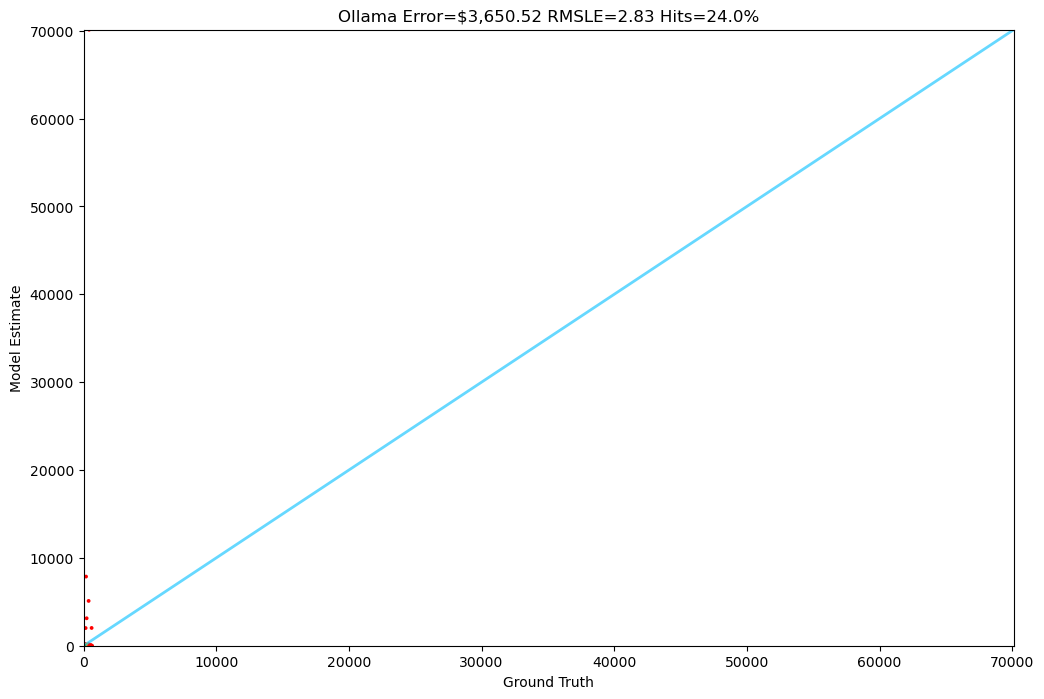

In [32]:
Tester.test(ollama, test)

In [32]:
api_key = os.getenv('OPENROUTER_API_KEY')
MODEL = "deepseek/deepseek-r1-0528-qwen3-8b:free"

api_router = OpenRouter(system_message=system_message,api_key=api_key)
api_router.MODEL = MODEL

In [35]:
def openrouter(item):
    response = api_router.chat(messages_for(item))
    reply = response
    return get_price(reply)

In [36]:
openrouter(test[0])

185.0

In [38]:
Tester.test(openrouter,test)

1: Guess: $300.00 Truth: $374.41 Error: $74.41 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $100.00 Truth: $225.11 Error: $125.11 SLE: 0.65 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $14.49 Truth: $61.68 Error: $47.19 SLE: 1.95 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $299.00 Truth: $599.99 Error: $300.99 SLE: 0.48 Item: HP Premium 17.3-inch HD Plus Touchscreen...


HTTPError: 429 Client Error: Too Many Requests for url: https://openrouter.ai/api/v1/chat/completions

In [ ]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [ ]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

In [ ]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

In [ ]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(claude_3_point_5_sonnet, test)

In [6]:
questions = [
    "What is the capital of France?",
    "Who wrote the novel 1984?",
    "Explain Newton's second law in simple words.",
    "What is the square root of 256?",
    "Summarize the causes of World War I.",
    "What are the main differences between Python and Java?",
    "Give me a recipe for making pasta.",
    "What does HTTP stand for?",
    "How does machine learning differ from deep learning?",
    "Translate 'Good morning' to Spanish.",
    "Who painted the Mona Lisa?",
    "What is the distance between Earth and the Moon?",
    "Explain recursion with an example.",
    "List 5 programming paradigms.",
    "What is blockchain technology?",
    "Who is the current UN Secretary-General?",
    "What is quantum entanglement?",
    "Give a motivational quote.",
    "What are the symptoms of dehydration?",
    "Explain how photosynthesis works."
]

In [7]:
from LLMHandler import LLMHandler
handler = LLMHandler(system_message="Answer in 2 lines")

In [8]:
res = {}
import time
for question in questions:
    response = handler.run(question,max_tokens=200,max_retries=1000)
    res[question] = response['text']
    print(f"Question: {question} \n Answer: {response['text']}\n\n")
    handler.clear_history()
    # 3. IMPORTANT: Still add the delay to avoid the IP rate limit
    print("--- Waiting for 2 seconds ---")
    time.sleep(2)

➡️ Attempt 1/1000 using key from 'sijanpaudel'...
Question: What is the capital of France? 
 Answer: The capital of France is Paris.


Conversation history cleared.
--- Waiting for 2 seconds ---
➡️ Attempt 1/1000 using key from 'sijan.paudel10'...
Question: Who wrote the novel 1984? 
 Answer: George Orwell wrote the novel 1984.


Conversation history cleared.
--- Waiting for 2 seconds ---
➡️ Attempt 1/1000 using key from 'paudelsijan15'...
Question: Explain Newton's second law in simple words. 
 Answer: Newton's second law states that the force acting on an object is equal to the mass of the object multiplied by its acceleration (F=ma). In simpler terms, the greater the force applied to an object, the faster it will accelerate in the direction of the force.


Conversation history cleared.
--- Waiting for 2 seconds ---
➡️ Attempt 1/1000 using key from 'aayushkafle'...
Question: What is the square root of 256? 
 Answer: The square root of 256 is 16.
Because 16 multiplied by itself (16 * 

In [91]:
train[0]

<Delphi FG0166 Fuel Pump Module = $226.95>